In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import ast
import random
import matplotlib.pyplot as plt

from torch.distributions import MultivariateNormal
from IPython.display import clear_output
import scipy.ndimage as ndimage
import os
import cv2
from torch.utils.data import DataLoader, Dataset
import metrics
import joblib
import copy
from torchvision import transforms
from enum import Enum
import faiss

from dataloaders import dataloader_MVTec_setup
from utils import get_files_masks, evaluate
from evaluate import evaluate_metrics, get_scores, load_model, visualize_result
from DQN import DQN
from environment import Environment

In [2]:
def parse_tuple(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        raise argparse.ArgumentTypeError(f"Invalid tuple: {value}")
parser = argparse.ArgumentParser()
# ------------ 
# setup
# ------------
parser.add_argument("--use_gpu", action="store_true", help="Use GPU for training")
#parser.add_argument("--data_root", type=str, default= "./../../../../scratch-beauty/zzhan762/data/MVTec_AD")
#parser.add_argument("--data_root", type=str, default= "./mvtec")
parser.add_argument("--data_root", type=str, default= "./data/mvtec")
parser.add_argument("--verbose", type=bool, default=True)
# ------------------ 
# feature extractor
# ------------------
parser.add_argument("--target_size", type=parse_tuple, default="(224,224)")
parser.add_argument("--resize_size", type=parse_tuple, default="(224,224)")
parser.add_argument("--class_name", type=str, default="toothbrush")
parser.add_argument("--batch_size", type=int, default=8)
parser.add_argument("--patch_size",type=int, default=3)
parser.add_argument("--target_embed_dimension", type=int, default=1024)
parser.add_argument("--edc", action="store_true")
parser.add_argument("--backbone", type=str,default="wide_resnet50_2")
parser.add_argument("--preprocessing_dimension", type=int, default=1024)

# ------------
# DQN 
# ------------
parser.add_argument("--action_dim", type=int, default=2)
parser.add_argument("--max_steps",type=int, default=int(4e4))
parser.add_argument("--eval_interval", type=int, default =int(1e3))
parser.add_argument("--lr",type=float,default = 0.00025)
parser.add_argument("--epsilon",type=float,default=1.0)
parser.add_argument("--epsilon_min",type=float,default=0.1)
parser.add_argument("--gamma", type=float, default=0.99)
parser.add_argument("--dqn_batch_size",type=int,default=32)
parser.add_argument("--warmup_steps",type=int, default=int(2e3))
parser.add_argument("--buffer_size",type=int,default=int(5e3))
parser.add_argument("--target_update_interval",type=int,default=int(5e3))

# ---------------
# Envirnment
# ---------------
parser.add_argument("--prob", type=float, default=0.5)
parser.add_argument("--max_samples",type=float,default=40)
parser.add_argument("--iForest_update_interval",type=int,default=int(2e3))
parser.add_argument("--iForest_max_samples",type=float,default=0.3)
parser.add_argument("--iForest_total_samples",type=int,default=int(1e6))
parser.add_argument("--iForest_batch_size",type=int,default=1024)


# -----------------------
# components
# -----------------------
parser.add_argument("--use_prioritized", type=bool, default=False)
parser.add_argument("--use_intrinsic",type=bool, default=False)
parser.add_argument("--use_copypaste", type=bool, default=True)
parser.add_argument("--use_faiss", type=bool, default=False)


args = parser.parse_args(['--use_gpu'])

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() and args.use_gpu else "cpu")
print('device: {}'.format(device))
args.backbone = 'wide_resnet50_2'
args.layers = ['layer2','layer3']
args.hidden_sizes = [512,256,128]
args.state_dim = args.target_embed_dimension

device: cuda


wood
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
zipper
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


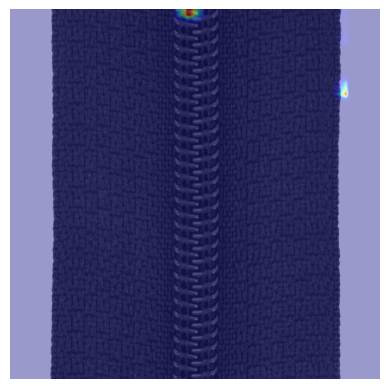

In [4]:
target_root ='./outputs'
#classes = [item for item in os.listdir(args.data_root) if not item.endswith('.txt')]
#classes = ["toothbrush"]
#assert (len(classes) == 15)
classes = ["wood","zipper"]
for class_name in classes:
    print(class_name)
    checkpoint_path = './checkpoints/mvtec_10_update200/dqn_'+class_name + '_10_best.pt'
    scores_dict = get_scores(checkpoint_path,device)
    for i in range(len(scores_dict['files'])):
        file = scores_dict['files'][i]
        file_components = file.split(os.sep)
        file_name = file_components[-1]
        defect_name = file_components[-2]
        
        heatmap = scores_dict['total_scores'][i]
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        heatmap = cv2.resize(heatmap,(image.shape[1], image.shape[0]))
        heatmap = cv2.normalize(heatmap, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
        plt.imshow(overlay)
        plt.axis('off')
        target_file = os.path.join(target_root, class_name,defect_name,file_name)
        directory = os.path.dirname(target_file)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(target_file,bbox_inches='tight', pad_inches=0)
